L2-regularized logistic regression for binary or multiclass classification; trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals and prints out the strongest coefficients for each class.

In [1]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter, defaultdict
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            Y.append(label)

    return X, Y


In [51]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY,min_feature = 2, training_iter = 1000):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=min_feature
        self.log_reg = None
        self.train_iter = training_iter

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        print("Number of features: {}".format(F))
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=self.train_iter)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

            print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
        return self.log_reg.score(self.testX, self.testY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [18]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats



In [19]:
trainX, trainY=load_data("/content/drive/MyDrive/INFO 159/train.txt")
s = trainX[0]
print(s)
# The pattern to match any text enclosed in double quotes
pattern = r'(?:["\'])+(.*?)(?:["\'])+'
pattern1 = r'#(.*?)<<NEWL>>'

import re 
# Using re.findall() to find all matching segments
quoted_segments = re.findall(pattern, s)
print(quoted_segments)

"""""""A simple log mechanism styled after PEP 282.""""""<<NEWL>><<NEWL>># The class here is styled after PEP 282 so that it could later be<<NEWL>># replaced with a standard Python logging implementation.<<NEWL>><<NEWL>>import sys<<NEWL>><<NEWL>>DEBUG = 1<<NEWL>>INFO = 2<<NEWL>>WARN = 3<<NEWL>>ERROR = 4<<NEWL>>FATAL = 5<<NEWL>><<NEWL>><<NEWL>>class Log:<<NEWL>>    def __init__(self, threshold=WARN):<<NEWL>>        self.threshold = threshold<<NEWL>><<NEWL>>    def _log(self, level, msg, args):<<NEWL>>        if level not in (DEBUG, INFO, WARN, ERROR, FATAL):<<NEWL>>            raise ValueError('%s wrong log level' % str(level))<<NEWL>><<NEWL>>        if level >= self.threshold:<<NEWL>>            if args:<<NEWL>>                msg = msg % args<<NEWL>>            if level in (WARN, ERROR, FATAL):<<NEWL>>                stream = sys.stderr<<NEWL>>            else:<<NEWL>>                stream = sys.stdout<<NEWL>>            try:<<NEWL>>                stream.write('%s\n' % msg)<<NEWL>> 

In [44]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

In [78]:
def manual_feature(text):
  """
  The input is a string of arbitrary length
  """
  #bag of words feature
  feats = defaultdict(int)
  words = nltk.word_tokenize(text)
  for word in set(words):
    word=word.lower()
    feats[word]=1

  target = {"'","''","#"}
  #count the number of comments 
  for word in words:
    if word in target:
      feats["contains info"] += 1
  feats["contains info"]/=len(text)
  import re 
  pattern_string = r'(?:")+(.*?)(?:")+'
  #find all strings between double quotes and single quotes
  quoted_segments = re.findall(pattern_string, text)
  feats["amount of docstrings"] = sum([len(s) for s in quoted_segments])/len(text)

  pattern_comment = r'#(.*?)<<NEWL>>'
  #find all comments
  quoted_segments = re.findall(pattern_comment, text)
  feats["amount of comments"] = sum([len(s) for s in quoted_segments])/len(text)



  return feats



In [67]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [68]:
def run(trainingFile, devFile, testFile, featurization_funciton, feature_count=2, training_iter = 1000):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    
    simple_classifier = Classifier(featurization_funciton, trainX, trainY, devX, devY, testX, testY,feature_count, training_iter)
    simple_classifier.train()
    accuracy=simple_classifier.test()
    
    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()
    return simple_classifier
    


In [74]:
trainingFile = "/content/drive/MyDrive/INFO 159/train.txt"
devFile = "/content/drive/MyDrive/INFO 159/dev.txt"
testFile = "/content/drive/MyDrive/INFO 159/test.txt"
  
classifier = run(trainingFile, devFile, testFile,binary_bow_featurize, 2,1000)


Number of features: 2923
C: 0.1, Train accuracy: 0.973, Dev accuracy: 0.620
C: 1, Train accuracy: 0.990, Dev accuracy: 0.610
C: 10, Train accuracy: 0.990, Dev accuracy: 0.610
C: 100, Train accuracy: 0.990, Dev accuracy: 0.620
Test accuracy for best dev model: 0.520, 95% CIs: [0.422 0.618]

0	0.191	__init__
0	0.141	==
0	0.124	bucket
0	0.119	under
0	0.113	mit
0	0.113	@
0	0.109	version
0	0.106	license
0	0.102	licensed
0	0.102	notice

1	0.254	as
1	0.190	#
1	0.172	class
1	0.165	with
1	0.164	handle
1	0.158	+=
1	0.158	sys
1	0.155	200
1	0.143	so
1	0.133	pytest.mark.parametrize

2	0.256	one
2	0.244	.
2	0.212	other
2	0.212	is
2	0.201	isinstance
2	0.183	os
2	0.163	r
2	0.154	2022
2	0.152	string
2	0.142	os.path.join

3	0.245	or
3	0.228	to
3	0.210	specified
3	0.196	of
3	0.192	a
3	0.191	given
3	0.188	are
3	0.182	bool
3	0.174	#
3	0.170	all

4	0.336	https
4	0.256	`
4	0.181	returns
4	0.179	python
4	0.172	'
4	0.164	use
4	0.164	method
4	0.162	value
4	0.159	to
4	0.148	examples



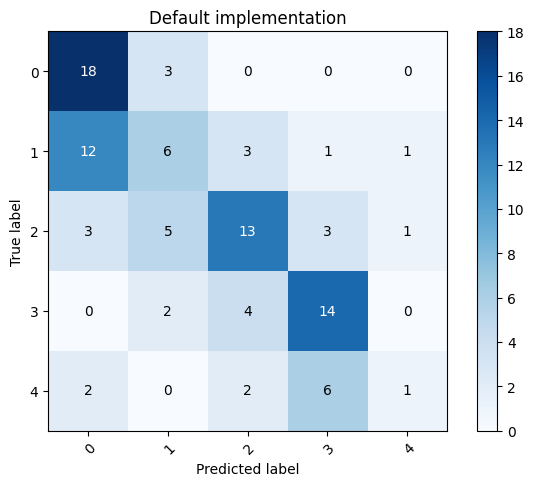

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot(classifier):
  labels = classifier.testY  # Get unique labels from y_test
  predictions = classifier.log_reg.predict(classifier.testX)

  # Calculate confusion matrix
  cm = confusion_matrix(labels, predictions, labels=np.unique(labels))  # Calculate confusion matrix

  # Draw confusion matrix
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=np.unique(labels), yticklabels=np.unique(labels),
        xlabel='Predicted label',
        ylabel='True label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  fmt = 'd' # format
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")

  fig.tight_layout()
  plt.title("Default implementation")
  plt.show()

plot(classifier)

In [79]:
classifier = run(trainingFile, devFile, testFile,manual_feature, 20, 2000)


Number of features: 234
C: 0.1, Train accuracy: 0.867, Dev accuracy: 0.600
C: 1, Train accuracy: 0.970, Dev accuracy: 0.570
C: 10, Train accuracy: 0.980, Dev accuracy: 0.580
C: 100, Train accuracy: 0.980, Dev accuracy: 0.590
Test accuracy for best dev model: 0.540, 95% CIs: [0.442 0.638]

0	0.275	__init__
0	0.202	under
0	0.189	version
0	0.186	amount of docstrings
0	0.168	more
0	0.162	==
0	0.158	licensed
0	0.154	!
0	0.140	without
0	0.134	data

1	0.329	as
1	0.282	with
1	0.260	#
1	0.242	s
1	0.236	+=
1	0.233	sys
1	0.224	class
1	0.218	valueerror
1	0.196	so
1	0.182	by

2	0.363	one
2	0.332	.
2	0.330	isinstance
2	0.303	is
2	0.272	os
2	0.262	r
2	0.213	string
2	0.185	print
2	0.179	object
2	0.170	list

3	0.319	or
3	0.301	of
3	0.299	a
3	0.298	are
3	0.296	name
3	0.283	to
3	0.271	so
3	0.269	#
3	0.266	which
3	0.262	path

4	0.537	https
4	0.394	`
4	0.301	use
4	0.294	'
4	0.291	python
4	0.289	value
4	0.235	1
4	0.223	this
4	0.221	at
4	0.220	to



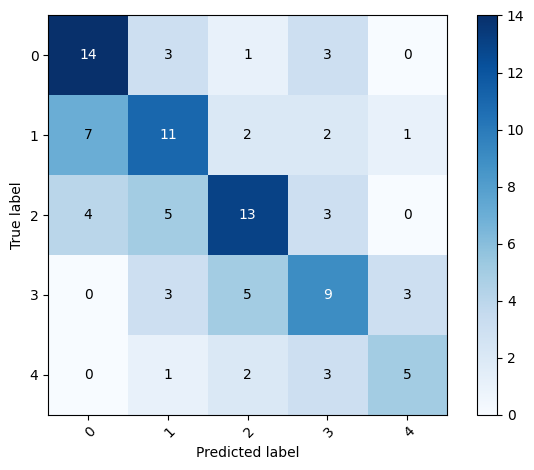

In [16]:
plot(classifier)